In [1]:
import os
from pathlib import Path
os.chdir(os.path.join(Path(os.path.abspath('')).parent.resolve()))
print(os.getcwd())

import sys
sys.path.append(os.path.dirname(os.path.realpath(Path(os.path.abspath('')).parent.resolve())))

import shap
import torch

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from src.train_LSTM import *

/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance


In [2]:
pred = 6
imp = 'zero'
resample_rate = None

root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')
data_split = np.load(os.path.join(root_folder, 'data_split.npy'), allow_pickle=True).item()
X_test = data_split['X_test']
y_test = data_split['y_test']
X_train = data_split['X_train'] + data_split['X_val']
y_train = data_split['y_train'] + data_split['y_val']

feature_static = pd.read_csv(
    os.path.join(data_folder, 'pos', 'info', os.listdir(os.path.join(data_folder, 'pos', 'info'))[0]),
    sep=';', header=0, index_col=[0]).columns.to_list()
feature_ts = pd.read_csv(
    os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
    sep=';', header=0, index_col=[0, 1]).columns.to_list()


n_layer = 2
n_hidden = 64
n_hidden_dense = 32

config = {
    "n_input_static": 4,
    "n_input_seq": 33,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imp,
}

model_file = 'models/LSTM_torch/2layer/version_13_6_z_5/pred6-impzero-samplingNone-epoch86-val_roc0.91.ckpt'
model = LSTM_CLF.load_from_checkpoint(checkpoint_path=model_file,
                                     config=config, data_folder=data_folder, data_split=data_split)
model.eval()

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


LSTM_CLF(
  (lstm_layer): LSTM(33, 64, num_layers=2, batch_first=True, dropout=0.75)
  (output_layer): Linear(in_features=68, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [3]:
np.random.seed(0)
torch.manual_seed(0)

# model.to(device='cuda')
model.to(device='cpu')

ds_background = PatientDataset(data_folder, X_train, y_train, resample_rate=resample_rate, imputation=imp)
loader_background = DataLoader(ds_background, batch_size=500,
                               sampler=ImbalancedDatasetSampler(ds_background), num_workers=2)
data_background = next(iter(loader_background))

ds_shap = PatientDataset(data_folder, X_test, y_test, resample_rate=resample_rate, imputation=imp)
loader_shap = DataLoader(ds_shap, batch_size=int(.02*(ds_shap.__len__())),
                         sampler=ImbalancedDatasetSampler(ds_shap), num_workers=2)
data = next(iter(loader_shap))

for d in data_background['data']:
    data_background['data'][d] = data_background['data'][d].to(device='cpu')
data_background['label'].to(device='cpu')

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cpu')
data['label'].to(device='cpu');

In [4]:
e = shap.DeepExplainer(
    model,
    [data_background['data']['static'], data_background['data']['time_series']],
)

shap_values = e.shap_values(
    [data['data']['static'][:100], data['data']['time_series'][:100]]
)


Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
shap_mean = []
for sv in shap_values[1]:
    tmp = sv[:, 4:]
    tmp = tmp.reshape(tmp.shape[0], 144, 33)
    shap_mean.append(np.mean(np.abs(tmp), axis=1))
    
    

array([ 1,  2,  3,  7,  9, 11, 13, 14, 16, 17, 18, 21, 23, 26, 28, 29, 30,
       31, 32, 34, 37, 38, 39, 40, 41, 42, 43, 50, 51, 53, 54, 55, 56, 57,
       58, 59, 61, 63, 64, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80,
       81, 82, 83, 84, 85, 89, 92, 94, 95, 96, 97, 99])

In [14]:
np.argmax(shap_values[1])/144/33

23.001052188552187

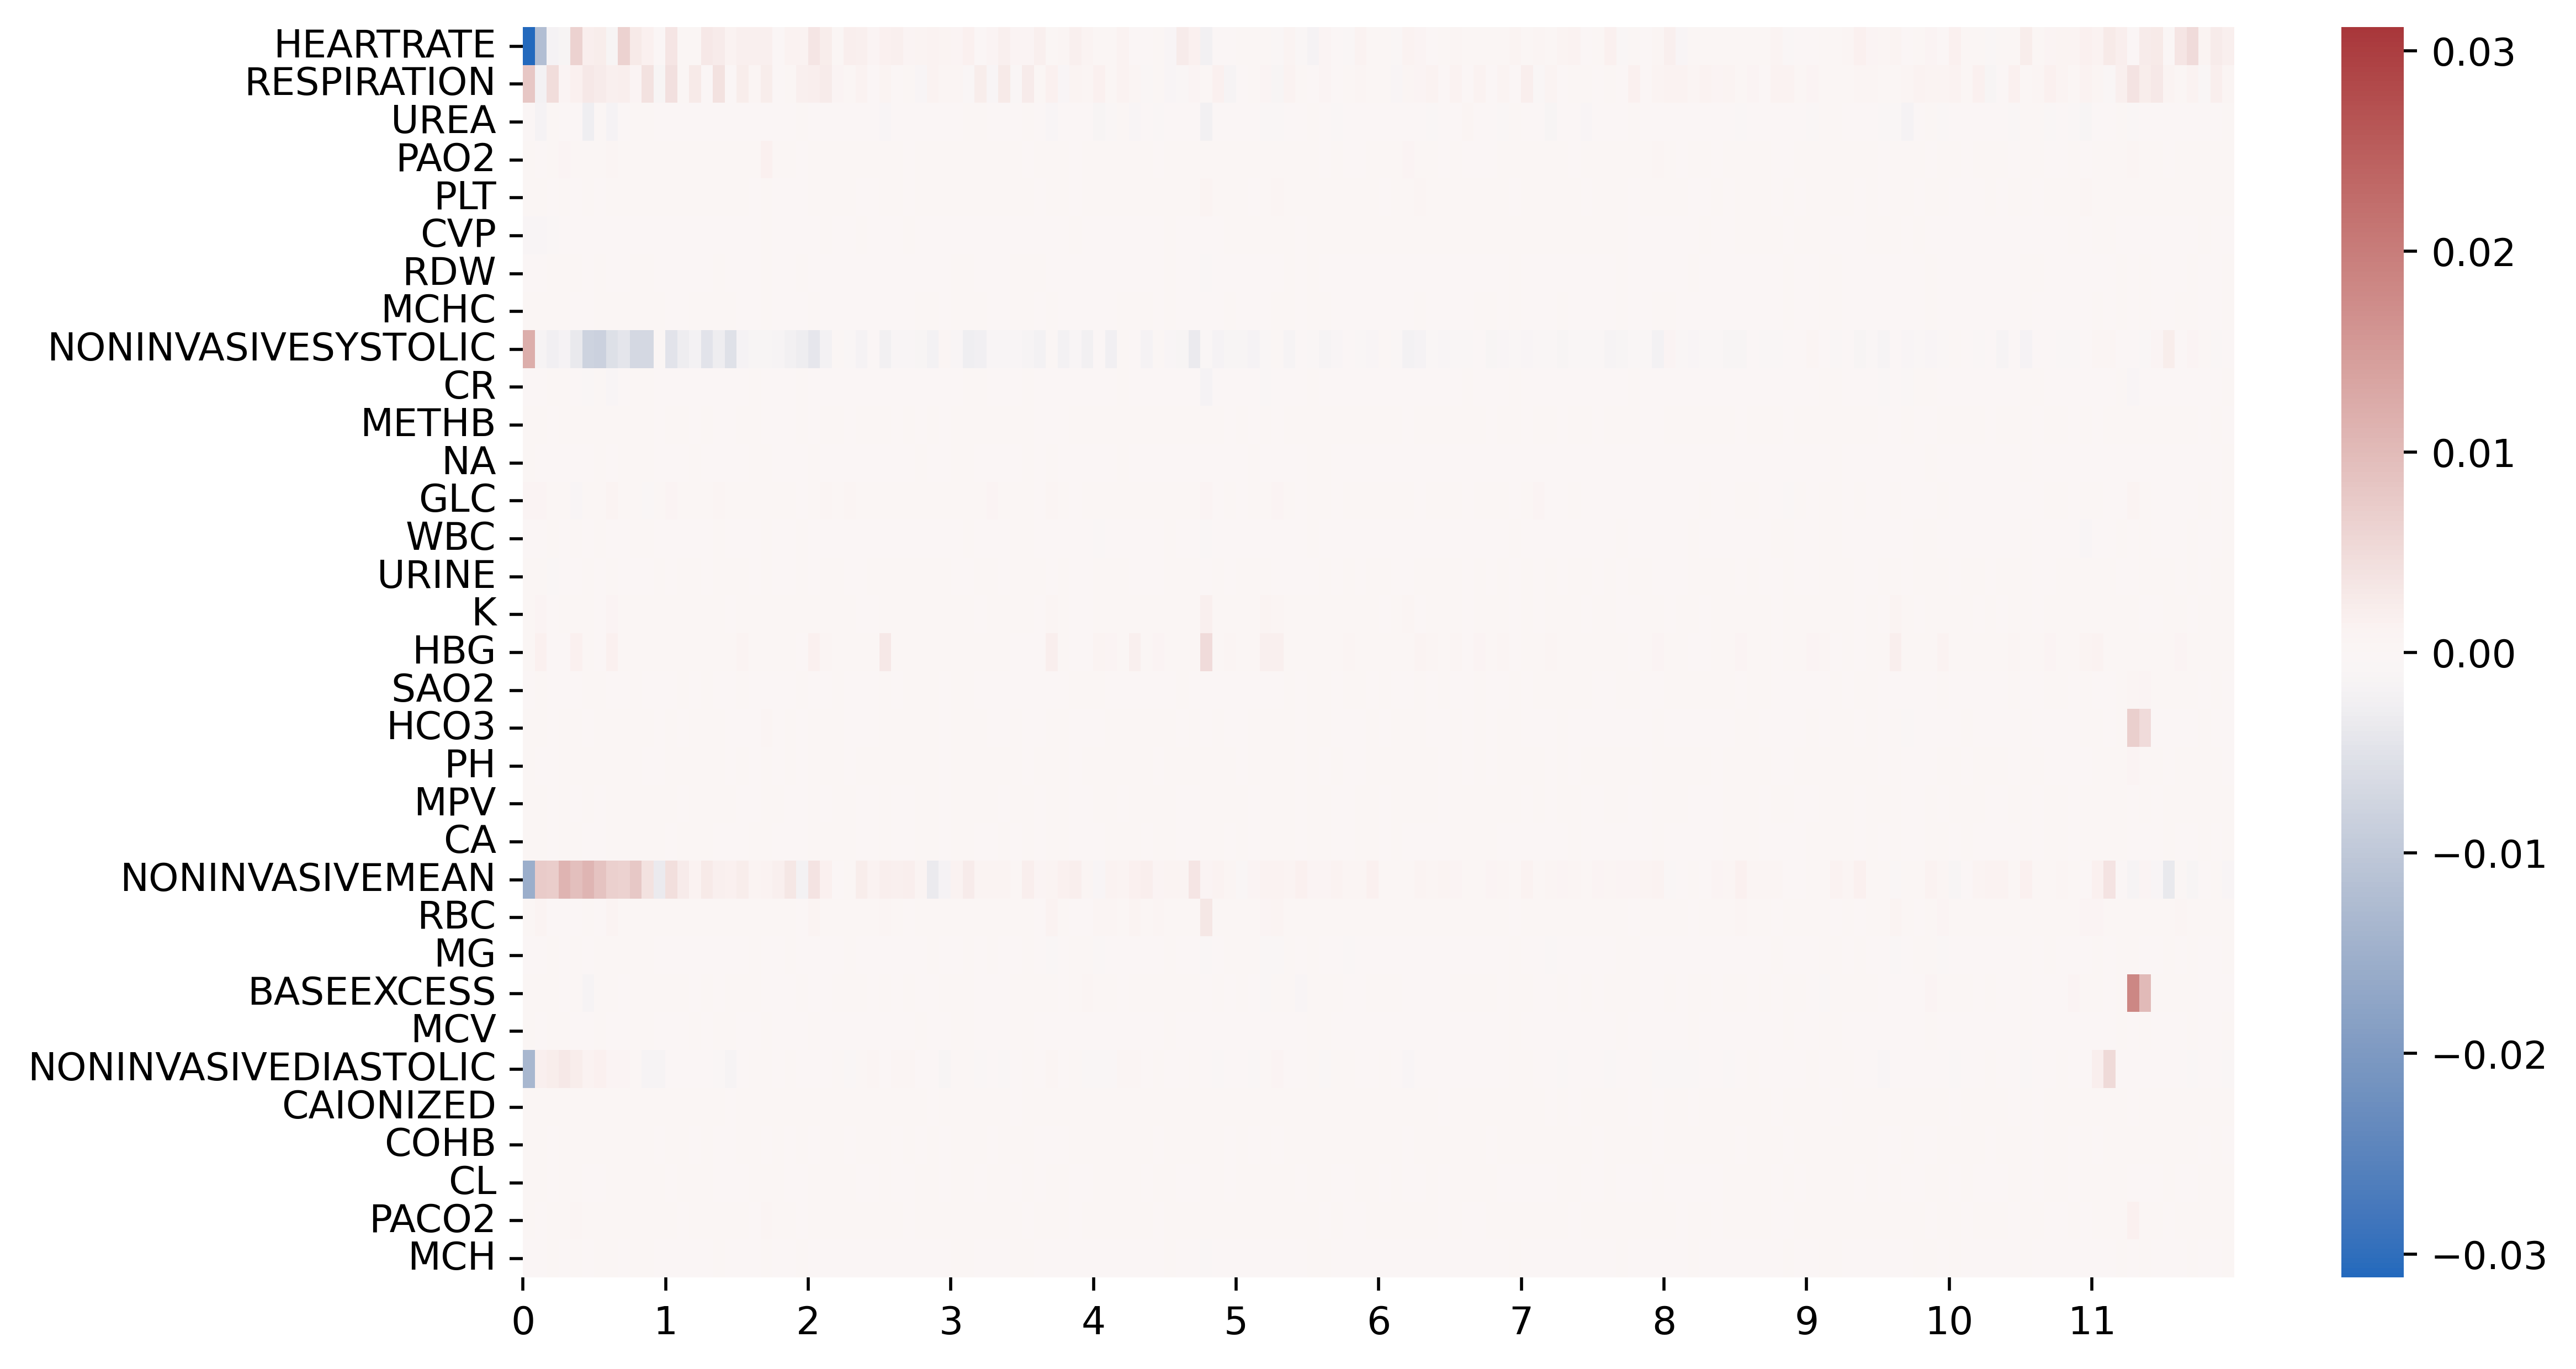

In [38]:
iii = 45

label_pos = np.where(np.array(data['label'][:100])==1)[0]
idx = label_pos[iii]

xlabels = [f'{xlabel}' for xlabel in np.arange(0, 144)]
feat_scores = shap_values[1][idx,:,:].T
fig, ax = plt.subplots(figsize=(10,6), dpi=500)
vmax = np.max(np.abs(feat_scores))
ax = sns.heatmap(feat_scores, yticklabels=feature_ts, xticklabels=xlabels, cmap='vlag', vmax=vmax, vmin=-vmax)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",rotation_mode="anchor");
plt.locator_params(axis='x', nbins=18)

ax.set_xticks([i*60/5 for i in range(12)]);
ax.set_xticklabels([i for i in range(12)]);

In [20]:
abnormal_signals = shap_values[1][idx,:,:].max(axis=0).argsort()[::-1]

data_origin = ds_shap.get_original_data(data['data']['time_series'][idx], 'time_series')
abnormal_data = np.array(data_origin)[:,abnormal_signals]
abnormal_data[abnormal_data<1e-6] = np.nan

# shap_mean = []
# for sv in shap_values[1]:
#     tmp = sv[:, 4:]
#     tmp = tmp.reshape(tmp.shape[0], 144, 33)
#     shap_mean.append(np.mean(np.abs(tmp), axis=1))

abnormal_feat = [feature_ts[i] for i in abnormal_signals]
abnormal_feat[:5]

['HEARTRATE', 'NONINVASIVEMEAN', 'RESPIRATION', 'UREA', 'NONINVASIVEDIASTOLIC']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HEARTRATE
NONINVASIVEMEAN
RESPIRATION
UREA
NONINVASIVEDIASTOLIC


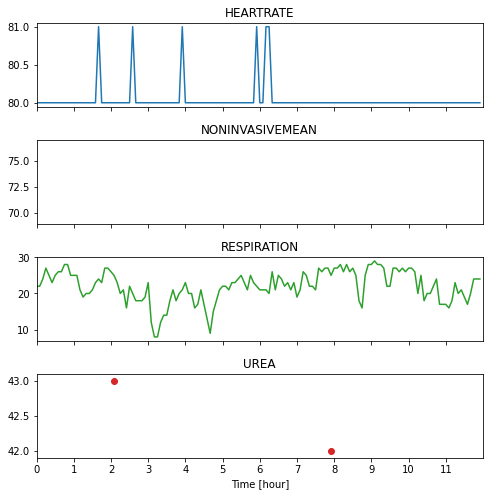

In [25]:
# define the colormap
cmap = plt.get_cmap('tab10')

vital_feat = ['HEARTRATE', 'NONINVASIVEMEAN', 'NONINVASIVEDIASTOLIC', 'NONINVASIVESYSTOLIC', 'RESPIRATION', 'CVP']

# max_shap = np.max(np.abs(shap_values[1][idx,:,:]))
shap_abnormal = shap_values[1][idx, :, abnormal_signals]
# shap_color = (shap_color + max_shap) / 2 / max_shap

fig, ax = plt.subplots(4, 1, figsize=(8,8), sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

count = 0
for i, feat in enumerate(abnormal_feat):
#     if feat in vital_feat:
#         continue
        
    print(feat)
    if count == 4:
        break
    y = np.array(abnormal_data[:, i])
    x = np.array(range(144))
    if sum(~np.isnan(y)) == 0:
        continue
        
    x_plot = x[~np.isnan(y)]
    y_plot = y[~np.isnan(y)]
    shap = shap_abnormal[i,:]
#     for si, s in enumerate(shap):
#         if s > 0.8*max(shap[~np.isnan(shap)]):
#             ax[count].axvspan(si-5, si+5, alpha=0.3, color='red')
#             print(si)
    
    count += 1
    if feat in vital_feat:
        ax[count-1].plot(x_plot, y_plot, label=feat, c=cmap(i))
        ax[count-1].set_xlim([0,144])
    else:
        ax[count-1].scatter(x_plot, y_plot, label=feat, c=cmap(i))
        ax[count-1].set_ylim([y_plot.min()-.1*(y_plot.max()-y_plot.min()), y_plot.max()+.1*(y_plot.max()-y_plot.min())])
        ax[count-1].set_xlim([0,144])
#     im = ax[count-1].scatter(x_plot, y_plot, label=feat, c=cmap(color), vmax=max_shap, vmin=-max_shap)
#     ax[count-1].set_ylim([y_plot.min()-.1*(y_plot.max()-y_plot.min()), y_plot.max()+.1*(y_plot.max()-y_plot.min())])
#     ax[count-1].set_xlim([0,144])
        
    ax[count-1].set_xticks([i*60/5 for i in range(12)])
    ax[count-1].set_xticklabels([i for i in range(12)])
    ax[count-1].set_title(f'{feat}')
plt.xlabel('Time [hour]');

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
